## Setup

First, we will connect to the correct runtime environment. Since we we are going to use deep learning, we would really benefit from having a GPU. Therefore, we will connect to a GPU runtime environment.

Select a Python with GPU runtime

- Click on Connect > Change the runtime

![Change runtime](https://drive.google.com/uc?export=view&id=1Rgloj9hRS-FZD9dQFN2IZXwSWs_rd8Rs)

- Select Runtime Python and with a GPU

![Select GPU runtime](https://drive.google.com/uc?export=view&id=13fBkTvz3gmtySh9QQWBDNT_msqD0xOiX)

Next, we install the necessary libraries.

In [11]:
!pip install bioio==3.0.0 bioio-czi==2.4.0 bioio-ome-tiff==1.4.0
!pip install cellpose

### Download the image dataset
We will work with a demo microscopy dataset in which HeLa cells have been stained using DAPI, and tubulin and mitochondria antibodies. Hereto, we will download the image dataset into our Google Drive.

In [12]:
import gdown

# a file
url = "https://drive.google.com/uc?id=1tR0yOZ7vOwMz43RacDNw77oGi50pbBrd"
image_path = "/content/hela_prolongdiamond_dapi_tubulin-af488_mitochondria-af568_40x.czi"
gdown.download(url, image_path)

Downloading...
From: https://drive.google.com/uc?id=1tR0yOZ7vOwMz43RacDNw77oGi50pbBrd
To: /content/hela_prolongdiamond_dapi_tubulin-af488_mitochondria-af568_40x.czi
100%|██████████| 88.2M/88.2M [00:00<00:00, 164MB/s]


'/content/hela_prolongdiamond_dapi_tubulin-af488_mitochondria-af568_40x.czi'

## Loading image data

We will work with the same image as in notebooks 2 and 3. We load the image in, select the DAPI (nuclei) and tubulin (cytoplasm) channels, and convert them to a numpy array.

In [13]:
from bioio import BioImage
import numpy as np

image_path = "/content/hela_prolongdiamond_dapi_tubulin-af488_mitochondria-af568_40x.czi"


# Get a BioImage object
img = BioImage(image_path)  # selects the first scene found

print("img shape: {}".format(img.shape))
print("Dimension order: {}".format(img.dims.order))

image_scale = [img.physical_pixel_sizes.Z, img.physical_pixel_sizes.Y, img.physical_pixel_sizes.X]
print("Dimension order: {}".format(image_scale))

color_map = 'cyan'

nuclei_cell_image = img.get_image_data("CZYX", T=0)[[1, 2], :, :, :].squeeze()
print(nuclei_cell_image.shape)

img shape: (1, 3, 14, 512, 512)
Dimension order: TCZYX
Dimension order: [1.0, 0.4151329104819196, 0.4151329104819196]
(2, 14, 512, 512)


### Maximum intensity projection
Now, create a macimum intensity projection of the image along the Z axis. Call it `nuclei_cell_image_MIP`.


In [14]:
# Exercise cell: Obtain a maximum intensity projection of the image along the Z axis
nuclei_cell_image_MIP = np.max(nuclei_cell_image, axis=1)
print(nuclei_cell_image_MIP.shape)

(2, 512, 512)


### Cell Segmentation using Cellpose

Now it is time to create a Cellpose model, load in the pretrained weights, and run it to segment the cells in our maximum intensity projection.



In [15]:
from cellpose import models

# Initialize model with GPU support based on argument
cyto_model = models.CellposeModel(gpu=True)

# Define the parameters
diameter = 60 # in pixels, set to 0 to let the model estimate the diameter
channel_axis = 0 # first axis is the channel axis
do_3D = False # enable 3D processing
cellprob_threshold = 0.0 # all pixels with value above threshold kept for masks, decrease to find more and larger masks. Defaults to 0.0.
flow_threshold = 0.4 #if do_3D and flow3D_smooth>0, smooth flows with gaussian filter of this stddev. Defaults to 0.

# Run segmentation in 2D
masks, flows, styles = cyto_model.eval(
    nuclei_cell_image_MIP,
    diameter=diameter,
    channel_axis=channel_axis,
    do_3D=do_3D,
    cellprob_threshold=cellprob_threshold,
    flow_threshold=flow_threshold,
)

Lets visualize the results.

You will see the predicted cell outlines, the corresponding cell masks, and the predicted flows. These flows were predicted by the model and were used to calculate the cell mask boundaries.

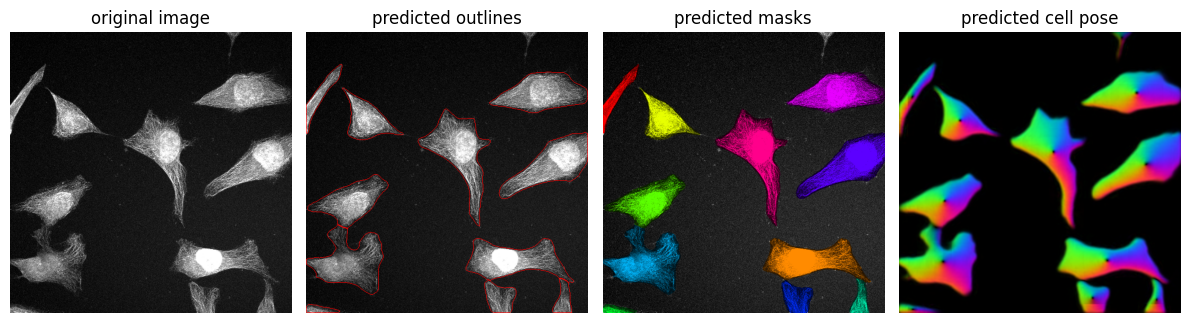

In [16]:


%matplotlib inline
import matplotlib.pyplot as plt
from cellpose import plot

channels = [0,1]
fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, nuclei_cell_image_MIP.squeeze(), masks, flows[0], channels=channels)
plt.tight_layout()
plt.show()



## Store the segmentation masks

With `bioio`, we will now store the segmentation results.

In [17]:
import bioio_base as biob
from bioio_ome_tiff.writers import OmeTiffWriter
import os

output_path="/content/cellpose_cell_masks.ome.tiff"

write_dim_order = "YX"  # required, the dimension order to write the data in
pixel_size = biob.types.PhysicalPixelSizes(img.physical_pixel_sizes.Z, img.physical_pixel_sizes.Y, img.physical_pixel_sizes.X)  # optional, Z, Y, X in microns

print(masks.shape)
OmeTiffWriter.save(
        masks,
        output_path,
        write_dim_order,
        physical_pixel_sizes=pixel_size,
    )



(512, 512)
